<a href="https://colab.research.google.com/github/AAhmadS/deeplearning-HW3/blob/main/HW3_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Deep Learning HW3-2

**Student name :** Amirahmad Shafiee

**Student number :** 99104027

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
%cd /content/gdrive/MyDrive/DeepLearning3

/content/gdrive/.shortcut-targets-by-id/1TGJQP4p9Bq7FDjSBi1WgjxUkXn56DW9j/DeepLearning3


In [4]:
import torch.nn as nn
import numpy as np
import pandas as pd
import random
import torch
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split as tts
import seaborn
import torch
from sklearn.preprocessing import StandardScaler
import glob
import matplotlib.image as mpimg
from PIL import Image
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import learning_curve
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_auc_score , f1_score
from sklearn.metrics import accuracy_score as acs 
from torch.utils.data import DataLoader
from torchvision.models import resnet50, ResNet50_Weights,resnet18,ResNet18_Weights
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from itertools import product

In [5]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Using {device} for inference')

Using cuda for inference


#Section A :

Loading data and preprocessing data

In [6]:
data_dir = './data'
transform = transforms.Compose([transforms.Resize((224,224))
                                ,transforms.RandomHorizontalFlip()
                                ,transforms.ToTensor()
                                ])
train_data = CIFAR10(root=data_dir, train=True, download=True, transform=transform)
testset = CIFAR10(root=data_dir, train=False, download=True, transform=transform)

train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True, num_workers=2)
test_dataloader = DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)


Files already downloaded and verified
Files already downloaded and verified


#Subsection :

Defining important functions.

In [7]:
def onehot(Y,num):
    out = torch.zeros((Y.size()[0],num))
    for i,index in enumerate(Y):
        out[i,index.item()] = 1
    return out 

    
def train_loop_cnn(train_dataloader, model, loss_fn, optimizer):
    count = 0
    total_loss = 0
    acc = 0
    size = 0
    for (x,y) in train_dataloader:
        x = x.type(torch.float).to(device)
        y = onehot(y.type(torch.int).reshape(-1,1),10).to(device)
        size += y.size()[0]
        # Compute prediction and loss
        pred = model(x)
        preds = torch.argmax(pred,dim=1,keepdim=True)
        main_y = torch.argmax(y,dim=1,keepdim=True)
        acc += (preds == main_y).type(torch.int).sum().item()
        loss = loss_fn(pred,y)
        total_loss += loss 
        count += 1
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return total_loss.item()/count , acc/size
    


def test_loop_cnn(test_dataloader, model, loss_fn):
    correct=0
    loss = 0
    data_size = 0
    with torch.no_grad():
      for (x,y) in test_dataloader:
        x = x.type(torch.float).to(device)
        y = y.type(torch.int).reshape(-1,1).to(device)
        data_size += y.size()[0]
        
        pred = model(x)
        preds = torch.argmax(pred,dim=1,keepdim=True)

        correct += (preds == y).type(torch.int).sum().item()

        loss += loss_fn(pred,onehot(y,10).to(device))
        
    return correct/data_size,loss.item()/(data_size/128)
  
def test_pred_cnn(test_dataloader,model):
    pred = torch.empty((0,1)).to(device)
    Y = torch.empty((0,1)).to(device)
    with torch.no_grad():
      for (x,y) in test_dataloader :
        x = x.type(torch.float).to(device)
        y = y.type(torch.int).reshape(-1,1).to(device)
        Y = torch.cat((Y,y))
        predd = model(x)
        preds = torch.argmax(predd,dim=1,keepdim=True)
        pred = torch.cat((pred,preds))
    return pred,Y

#Section A :
Training the model. Which is ResNet50, but only the last layer is trained.

In [ ]:
weights = ResNet50_Weights.DEFAULT
model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
for param in model.parameters():
      param.requires_grad = False

model.fc = nn.Sequential(
    nn.Linear(2048,10)
)

model = model.to(device)

loss_fn = nn.CrossEntropyLoss().to(device)

params = []
for name,param in model.named_parameters():
    if param.requires_grad == True:
        params.append(param)
        print(f"parameter to learn : {name}")

optimizer = torch.optim.Adam(params)


parameter to learn : fc.0.weight
parameter to learn : fc.0.bias


In [ ]:
train_loss = []
train_acc = []
test_acc = []

epochs = 20
for t in range(epochs):
    error, acc = train_loop_cnn(train_dataloader, model, loss_fn, optimizer)
    train_loss.append(error)
    train_acc.append(acc)

    t_acc , t_loss = test_loop_cnn(test_dataloader,model,loss_fn)
    test_acc.append(t_acc)

    if (t%3 == 2):
      print(f"loss of epoch {t+1} equals : {train_loss[t]}")
      print(f"Accuracy of epoch {t+1} equals : {train_acc[t]}")
      print(f"Accuracy of epoch {t+1} for validation set equals : {test_acc[t]}")
    
print("Done!")

loss of epoch 3 equals : 0.5328212650230778
Accuracy of epoch 3 equals : 0.82008
Accuracy of epoch 3 for validation set equals : 0.8114
loss of epoch 6 equals : 0.4862812949568414
Accuracy of epoch 6 equals : 0.8334
Accuracy of epoch 6 for validation set equals : 0.8095
loss of epoch 9 equals : 0.47244247085298113
Accuracy of epoch 9 equals : 0.83842
Accuracy of epoch 9 for validation set equals : 0.812
loss of epoch 12 equals : 0.4570354256788483
Accuracy of epoch 12 equals : 0.84122
Accuracy of epoch 12 for validation set equals : 0.8121
loss of epoch 15 equals : 0.4509045925286725
Accuracy of epoch 15 equals : 0.84256
Accuracy of epoch 15 for validation set equals : 0.8183
loss of epoch 18 equals : 0.4414340748506434
Accuracy of epoch 18 equals : 0.84704
Accuracy of epoch 18 for validation set equals : 0.8137
Done!


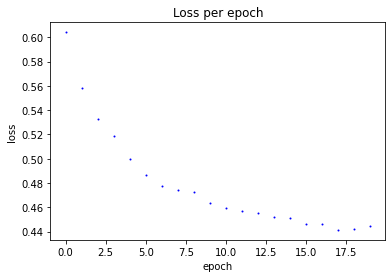

In [ ]:
plt.title("Loss per epoch")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.scatter(np.arange(start=0,stop=epochs),train_loss,s=1,c='blue')

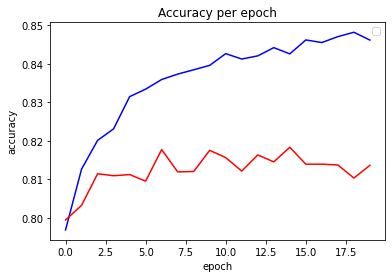

In [ ]:
plt.title("Accuracy per epoch")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.plot(np.arange(start=0,stop=epochs),train_acc,c='blue')
plt.plot(np.arange(start=0,stop=epochs),test_acc,c='red')
plt.legend()

In [ ]:
pred,y = test_pred_cnn(test_dataloader,model)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
acc,loss_t = test_loop_cnn(test_dataloader,model,loss_fn) 
print(f"the best model's loss on the test dataset is being : {loss_t}")

the best model's loss on the test dataset is being : 1.0963126953125


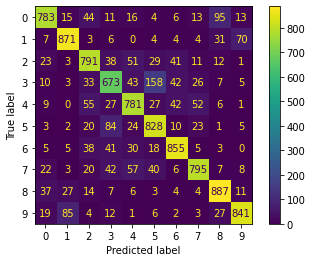

In [ ]:
confusion_matrix = metrics.confusion_matrix(y.to("cpu"),pred.to("cpu"))
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)
cm_display.plot()
plt.show()

In [ ]:
print(classification_report(y.to("cpu"),pred.to("cpu")))

              precision    recall  f1-score   support

         0.0       0.85      0.78      0.82      1000
         1.0       0.86      0.87      0.86      1000
         2.0       0.77      0.79      0.78      1000
         3.0       0.72      0.67      0.69      1000
         4.0       0.77      0.78      0.78      1000
         5.0       0.74      0.83      0.78      1000
         6.0       0.84      0.85      0.85      1000
         7.0       0.85      0.80      0.82      1000
         8.0       0.82      0.89      0.85      1000
         9.0       0.88      0.84      0.86      1000

    accuracy                           0.81     10000
   macro avg       0.81      0.81      0.81     10000
weighted avg       0.81      0.81      0.81     10000



In [ ]:
torch.save(model, 'resnet_sectionA.pth')

In [8]:
model = torch.load('resnet_sectionA.pth')

#Section B:

In [9]:
def train_loop_teacher(train_dataloader, model, teacher, loss_fn, optimizer,alpha,taw):
    count = 0
    total_loss = 0
    acc = 0
    size = 0
    for (x,y) in train_dataloader:
        x = x.type(torch.float).to(device)
        y = onehot(y.type(torch.int).reshape(-1,1),10).to(device)
        y_teacher = teacher(x)/taw
        size += y.size()[0]
        # Compute prediction and loss
        pred = model(x)
        preds = torch.argmax(pred,dim=1,keepdim=True)
        main_y = torch.argmax(y,dim=1,keepdim=True)
        acc += (preds == main_y).type(torch.int).sum().item()
        
        loss_1 = loss_fn(nn.Softmax(dim=1)(pred),y)
        loss_2 = loss_fn(nn.Softmax(dim=1)(pred/taw),nn.Softmax(dim=1)(y_teacher))
        loss = (1-alpha) * loss_1 +(alpha * taw**2) * loss_2
        total_loss += loss 

        count += 1
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return total_loss.item()/count , acc/size

In [10]:
teacher = model
teacher.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [11]:
def create_student():
  student = resnet18()
  student.fc = nn.Sequential(
      nn.Linear(512,10)
  )

  model = student.to(device)

  params = []
  for name,param in model.named_parameters():
      if param.requires_grad == True:
          params.append(param)

  optimizer = torch.optim.Adam(params)
  return model,optimizer

In [ ]:
#searching for the best parameters 
loss_fn = nn.CrossEntropyLoss().to(device)
alpha_list = [0.8,0.9]
taw_list = [4,3]
best_acc = 0
best_duo = (0.1,4)
for taw,alpha in product(taw_list,alpha_list):
  model,optmizer = create_student()
  error, acc = train_loop_teacher(train_dataloader, model, teacher, loss_fn, optimizer,alpha,taw)
  error, acc = train_loop_teacher(train_dataloader, model, teacher, loss_fn, optimizer,alpha,taw)
  print(f"error and accuracy of model tuned with hyperparameters : {(taw,alpha)} , reached : {(error,acc)}")
  if (acc > best_acc):
    best_duo = (taw,alpha)
    best_acc = acc
print(f"best results were gained when taw and alpha were set to :{best_duo}\t with accuracy :{best_acc} on the train set")
taw,alpha = best_duo

error and accuracy of model tuned with hyperparameters : (4, 0.8) , reached : (29.933518821930946, 0.10062)
error and accuracy of model tuned with hyperparameters : (4, 0.9) , reached : (33.38636658807545, 0.1168)
error and accuracy of model tuned with hyperparameters : (3, 0.8) , reached : (17.041034357017264, 0.07332)
error and accuracy of model tuned with hyperparameters : (3, 0.9) , reached : (18.879681755514707, 0.09222)
best results were gained when taw and alpha were set to :(4, 0.9)	 with accuracy :0.1168 on the train set


In [16]:
train_loss = []
train_acc = []
test_acc = []
model,optimizer = create_student()
loss_fn = nn.CrossEntropyLoss().to(device)
epochs = 12
for t in range(epochs):
    error, acc = train_loop_teacher(train_dataloader, model, teacher, loss_fn, optimizer,alpha,taw)
    train_loss.append(error)
    train_acc.append(acc)

    t_acc , t_loss = test_loop_cnn(test_dataloader,model,loss_fn)
    test_acc.append(t_acc)

    if (t%3 == 2):
      print(f"loss of epoch {t+1} equals : {train_loss[t]}")
      print(f"Accuracy of epoch {t+1} equals : {train_acc[t]}")
      print(f"Accuracy of epoch {t+1} for validation set equals : {test_acc[t]}")
    
print("Done!")

loss of epoch 3 equals : 30.438054467710998
Accuracy of epoch 3 equals : 0.6669
Accuracy of epoch 3 for validation set equals : 0.6769
loss of epoch 6 equals : 30.11399556425831
Accuracy of epoch 6 equals : 0.75848
Accuracy of epoch 6 for validation set equals : 0.7627
loss of epoch 9 equals : 29.9799117846867
Accuracy of epoch 9 equals : 0.80352
Accuracy of epoch 9 for validation set equals : 0.7823
loss of epoch 12 equals : 29.903645000799234
Accuracy of epoch 12 equals : 0.82886
Accuracy of epoch 12 for validation set equals : 0.8067
Done!


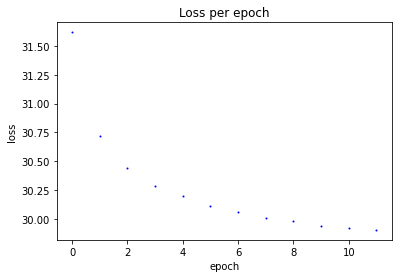

In [17]:
plt.title("Loss per epoch")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.scatter(np.arange(start=0,stop=epochs),train_loss,s=1,c='blue')

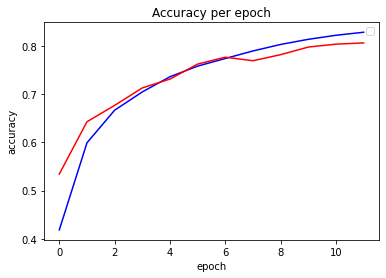

In [18]:
plt.title("Accuracy per epoch")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.plot(np.arange(start=0,stop=epochs),train_acc,c='blue')
plt.plot(np.arange(start=0,stop=epochs),test_acc,c='red')
plt.legend()

In [19]:
pred,y = test_pred_cnn(test_dataloader,model)

In [20]:
acc,loss_t = test_loop_cnn(test_dataloader,model,loss_fn) 
print(f"the best model's loss on the test dataset is being : {loss_t}")

the best model's loss on the test dataset is being : 5.991704296875


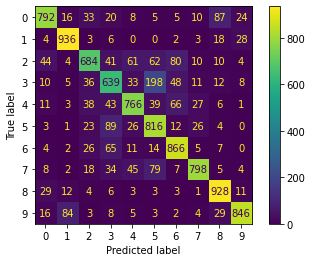

In [21]:
confusion_matrix = metrics.confusion_matrix(y.to("cpu"),pred.to("cpu"))
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)
cm_display.plot()
plt.show()

In [22]:
print(classification_report(y.to("cpu"),pred.to("cpu")))

              precision    recall  f1-score   support

         0.0       0.86      0.79      0.82      1000
         1.0       0.88      0.94      0.91      1000
         2.0       0.79      0.68      0.73      1000
         3.0       0.67      0.64      0.66      1000
         4.0       0.80      0.77      0.78      1000
         5.0       0.67      0.82      0.74      1000
         6.0       0.79      0.87      0.83      1000
         7.0       0.89      0.80      0.84      1000
         8.0       0.84      0.93      0.88      1000
         9.0       0.91      0.85      0.88      1000

    accuracy                           0.81     10000
   macro avg       0.81      0.81      0.81     10000
weighted avg       0.81      0.81      0.81     10000



In [23]:
torch.save(model, 'resnet_sectionB.pth')

#Section C :
Training Resnet18 without using our section a model as the teacher model. 

In [ ]:
student = resnet18()
student.fc = nn.Sequential(
    nn.Linear(512,10)
)

model = student.to(device)

loss_fn = nn.CrossEntropyLoss().to(device)

params = []
for name,param in model.named_parameters():
    if param.requires_grad == True:
        params.append(param)

optimizer = torch.optim.Adam(params)
alpha = 0.9
taw  = 4

In [ ]:
train_loss = []
train_acc = []
test_acc = []

epochs = 12
for t in range(epochs):
    error, acc = train_loop_cnn(train_dataloader, model, loss_fn, optimizer)
    train_loss.append(error)
    train_acc.append(acc)

    t_acc , t_loss = test_loop_cnn(test_dataloader,model,loss_fn)
    test_acc.append(t_acc)

    if (t%3 == 2):
      print(f"loss of epoch {t+1} equals : {train_loss[t]}")
      print(f"Accuracy of epoch {t+1} equals : {train_acc[t]}")
      print(f"Accuracy of epoch {t+1} for validation set equals : {test_acc[t]}")
    
print("Done!")

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


loss of epoch 3 equals : 0.6186412606397858
Accuracy of epoch 3 equals : 0.78492
Accuracy of epoch 3 for validation set equals : 0.8027
loss of epoch 6 equals : 0.3654847206057185
Accuracy of epoch 6 equals : 0.87408
Accuracy of epoch 6 for validation set equals : 0.843
loss of epoch 9 equals : 0.2217202735374041
Accuracy of epoch 9 equals : 0.92292
Accuracy of epoch 9 for validation set equals : 0.8615
loss of epoch 12 equals : 0.1307905445928159
Accuracy of epoch 12 equals : 0.95468
Accuracy of epoch 12 for validation set equals : 0.8641
Done!


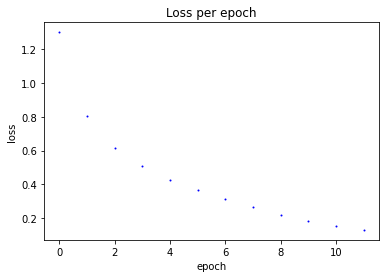

In [ ]:
plt.title("Loss per epoch")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.scatter(np.arange(start=0,stop=epochs),train_loss,s=1,c='blue')

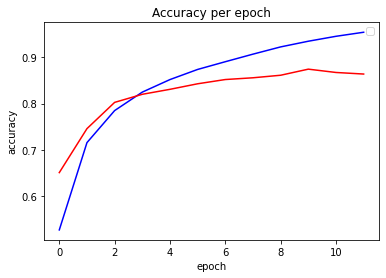

In [ ]:
plt.title("Accuracy per epoch")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.plot(np.arange(start=0,stop=epochs),train_acc,c='blue')
plt.plot(np.arange(start=0,stop=epochs),test_acc,c='red')
plt.legend()

In [ ]:
pred,y = test_pred_cnn(test_dataloader,model)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
acc,loss_t = test_loop_cnn(test_dataloader,model,loss_fn) 
print(f"the best model's loss on the test dataset is being : {loss_t}")

the best model's loss on the test dataset is being : 0.9239927734375


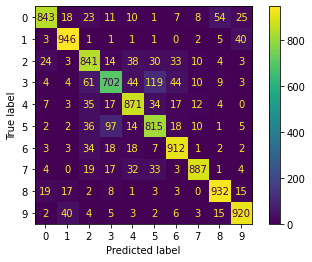

In [ ]:
confusion_matrix = metrics.confusion_matrix(y.to("cpu"),pred.to("cpu"))
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)
cm_display.plot()
plt.show()

In [ ]:
print(classification_report(y.to("cpu"),pred.to("cpu")))

              precision    recall  f1-score   support

         0.0       0.93      0.84      0.88      1000
         1.0       0.91      0.95      0.93      1000
         2.0       0.80      0.84      0.82      1000
         3.0       0.79      0.70      0.74      1000
         4.0       0.84      0.87      0.86      1000
         5.0       0.78      0.81      0.80      1000
         6.0       0.87      0.91      0.89      1000
         7.0       0.94      0.89      0.91      1000
         8.0       0.91      0.93      0.92      1000
         9.0       0.90      0.92      0.91      1000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



In [ ]:
torch.save(model, 'resnet_sectionC.pth')

##Subsection (Conclusion) :
Model C results have been better so far; Although we've been expecting the exact opposite. The reason behind the situation might be the fact tht we couldn't reach a satisfying accuracy in section A with the model playing the teacher role in the next section.

Anyways, In our opinion, the reason behind getting suitable results with distilation knowledge method, would be the fact that the bigger model would help the newer and smaller model to get past the nonlinearity in a much smoother and more efficient way.


#Section D :
Fine tuning resnet50 

In [ ]:
weights = ResNet50_Weights.DEFAULT
model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)

model.fc = nn.Sequential(
    nn.Linear(2048,10)
)

model = model.to(device)

loss_fn = nn.CrossEntropyLoss().to(device)

params = []
for name,param in model.named_parameters():
    if param.requires_grad == True:
        params.append(param)
print(f"#parameters to learn :{len(params)}")


optimizer = torch.optim.Adam(params)


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

#parameters to learn :161


In [ ]:
train_loss = []
train_acc = []
test_acc = []

epochs = 6
for t in range(epochs):
    error, acc = train_loop_cnn(train_dataloader, model, loss_fn, optimizer)
    train_loss.append(error)
    train_acc.append(acc)

    t_acc , t_loss = test_loop_cnn(test_dataloader,model,loss_fn)
    test_acc.append(t_acc)

    if (t%3 == 2):
      print(f"loss of epoch {t+1} equals : {train_loss[t]}")
      print(f"Accuracy of epoch {t+1} equals : {train_acc[t]}")
      print(f"Accuracy of epoch {t+1} for validation set equals : {test_acc[t]}")
    
print("Done!")

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


loss of epoch 3 equals : 0.22008229521534328
Accuracy of epoch 3 equals : 0.92402
Accuracy of epoch 3 for validation set equals : 0.9033
loss of epoch 6 equals : 0.12257483792122063
Accuracy of epoch 6 equals : 0.95722
Accuracy of epoch 6 for validation set equals : 0.9153


KeyboardInterrupt: ignored

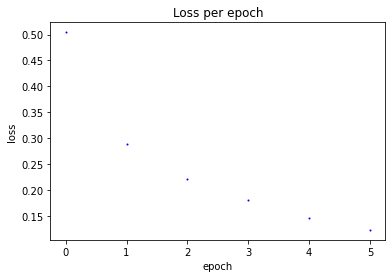

In [ ]:
plt.title("Loss per epoch")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.scatter(np.arange(start=0,stop=12),train_loss,s=1,c='blue')

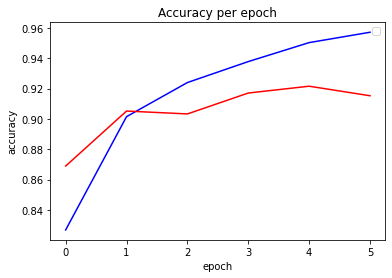

In [ ]:
plt.title("Accuracy per epoch")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.plot(np.arange(start=0,stop=6),train_acc,c='blue')
plt.plot(np.arange(start=0,stop=6),test_acc,c='red')
plt.legend()

**Due to Computation limitations, we split the training process into two parts**

In [ ]:
train_loss = []
train_acc = []
test_acc = []

epochs = 4
for t in range(epochs):
    error, acc = train_loop_cnn(train_dataloader, model, loss_fn, optimizer)
    train_loss.append(error)
    train_acc.append(acc)

    t_acc , t_loss = test_loop_cnn(test_dataloader,model,loss_fn)
    test_acc.append(t_acc)

    if (t%3 == 2):
      print(f"loss of epoch {t+1} equals : {train_loss[t]}")
      print(f"Accuracy of epoch {t+1} equals : {train_acc[t]}")
      print(f"Accuracy of epoch {t+1} for validation set equals : {test_acc[t]}")
    
print("Done!")

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


loss of epoch 3 equals : 0.07418445187151584
Accuracy of epoch 3 equals : 0.9743
Accuracy of epoch 3 for validation set equals : 0.9255
Done!


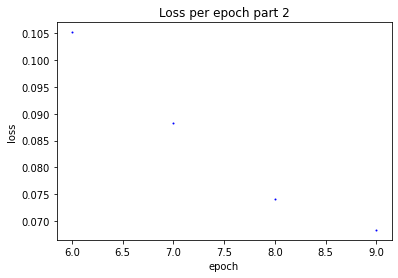

In [ ]:
plt.title("Loss per epoch part 2")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.scatter(np.arange(start=6,stop=10),train_loss,s=1,c='blue')

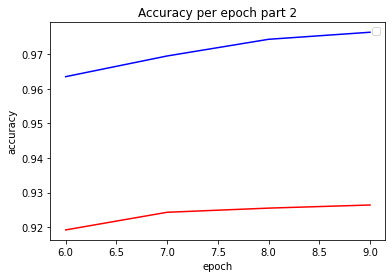

In [ ]:
plt.title("Accuracy per epoch part 2")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.plot(np.arange(start=6,stop=10),train_acc,c='blue')
plt.plot(np.arange(start=6,stop=10),test_acc,c='red')
plt.legend()

In [ ]:
pred,y = test_pred_cnn(test_dataloader,model)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
acc,loss_t = test_loop_cnn(test_dataloader,model,loss_fn) 
print(f"the best model's loss on the test dataset is being : {loss_t}")

the best model's loss on the test dataset is being : 0.5096337890625


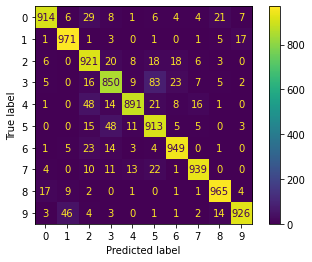

In [ ]:
confusion_matrix = metrics.confusion_matrix(y.to("cpu"),pred.to("cpu"))
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)
cm_display.plot()
plt.show()

In [ ]:
print(classification_report(y.to("cpu"),pred.to("cpu")))

              precision    recall  f1-score   support

         0.0       0.96      0.91      0.94      1000
         1.0       0.94      0.97      0.95      1000
         2.0       0.86      0.92      0.89      1000
         3.0       0.88      0.85      0.86      1000
         4.0       0.95      0.89      0.92      1000
         5.0       0.85      0.91      0.88      1000
         6.0       0.94      0.95      0.94      1000
         7.0       0.96      0.94      0.95      1000
         8.0       0.95      0.96      0.96      1000
         9.0       0.97      0.93      0.95      1000

    accuracy                           0.92     10000
   macro avg       0.93      0.92      0.92     10000
weighted avg       0.93      0.92      0.92     10000



In [ ]:
torch.save(model, 'resnet_sectionD.pth')

##Subsection (Comparison): 
Fine-tuning the whole model will result in conv layers to adapt to the new dataset in a somewhat better way. Therefore it is more likely to have better and more important features extracted before the FC layer.

**Personal Opinion:**
Even if both datasets come from the same distribution; due to the unstability of noise, It would always be nice to reduce the generality of layers involved directly to the dataset, and go for a bit of overfitting act over the smaller but important dataset.